# LAM TRINH DINH - INFO 6147 - PLANT TYPE CLASSIFICATION PROJECT

## Libraries

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm
import kagglehub
import shutil
import time
import torchvision

## Download dataset

In [2]:
# Download the dataset using kagglehub
path = kagglehub.dataset_download("yudhaislamisulistya/plants-type-datasets")
print("Path to dataset files:", path)

# Define the target directory
target_dir = "/content/plants-type-datasets"

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Check if the downloaded path is a zip file
if path.endswith('.zip'):
    # Unzip the dataset to the target directory
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Dataset unzipped to {target_dir}")
else:
    # If it's not a zip, copy the files to the target directory
    for item in os.listdir(path):
        s = os.path.join(path, item)
        d = os.path.join(target_dir, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)
    print(f"Dataset copied to {target_dir}")

Path to dataset files: /kaggle/input/plants-type-datasets
Dataset copied to /content/plants-type-datasets


## Normalization

Class labels: ['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant', 'galangal', 'ginger', 'guava', 'kale', 'longbeans', 'mango', 'melon', 'orange', 'paddy', 'papaya', 'peper chili', 'pineapple', 'pomelo', 'shallot', 'soybeans', 'spinach', 'sweet potatoes', 'tobacco', 'waterapple', 'watermelon']


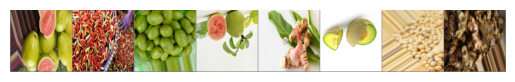

Labels: ['guava', 'peper chili', 'mango', 'guava', 'galangal', 'melon', 'soybeans', 'galangal']


In [4]:
#normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#split folders
dataset_path = "/content/plants-type-datasets/split_ttv_dataset_type_of_plants"
train_path = f"{dataset_path}/Train_Set_Folder"
val_path = f"{dataset_path}/Validation_Set_Folder"
test_path = f"{dataset_path}/Test_Set_Folder"

#load
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

#define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#classes
class_names = train_dataset.classes
print(f"Class labels: {class_names}")

#visualize some images
def imshow(img):
    img = img / 2 + 0.5  #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  #convert from (C, H, W) to (H, W, C)
    plt.axis("off")
    plt.show()

#get a batch of images from training set
data_iter = iter(train_loader)
images, labels = next(data_iter)

#show images
imshow(torchvision.utils.make_grid(images[:8]))  #8 images
print("Labels:", [class_names[label] for label in labels[:8]])


In [ ]:
print(val_dataset)

Dataset ImageFolder
    Number of datapoints: 3030
    Root location: /content/plants-type-datasets/split_ttv_dataset_type_of_plants/Validation_Set_Folder
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


## Convert to numpy, check label and shape

In [ ]:
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.numpy())  #convert to numpy
for _, labels in val_loader:
    all_labels.extend(labels.numpy())

num_classes = len(set(all_labels))  #unique class
max_label = max(all_labels)  #highest label
print(f"Number of unique classes: {num_classes}")
print(f"Maximum label value: {max_label}")

Number of unique classes: 30
Maximum label value: 29


In [ ]:
#check shape
images, _ = next(iter(train_loader))
print(f"Input shape: {images.shape}")

Input shape: torch.Size([32, 3, 224, 224])


## Regular CNN

In [ ]:
#2 convolutional layers
class PlantCNN(nn.Module):
    def __init__(self, num_classes, input_size=(3, 224, 224)):
        super(PlantCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self._to_linear = self._get_conv_output_size(input_size)
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_conv_output_size(self, input_size):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            x = self.pool(torch.relu(self.conv1(dummy_input)))
            x = self.pool(torch.relu(self.conv2(x)))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Return logits
        return x

#optimizer, loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 30
input_size = (3, 224, 224)
model = PlantCNN(num_classes, input_size=input_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()
#training normal cnn
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        train_loop.set_postfix(loss=running_loss / (train_loop.n + 1))

    train_accuracy = 100 * correct_train / total_train

    #validation
    model.eval()
    correct_val, total_val = 0, 0
    val_loss = 0.0

    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            val_loop.set_postfix(val_loss=val_loss / (val_loop.n + 1))

    val_accuracy = 100 * correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")
end_time = time.time()
regularcnn_time = end_time - start_time
print("Training complete!")
print("Training Regular CNN takes: ",regularcnn_time)
torch.save(model.state_dict(), "plant_cnn.pth")
print("Model saved as plant_cnn.pth")

Epoch 1/5, Loss: 2.4826, Train Accuracy: 25.13%, Val Loss: 1.8871, Val Accuracy: 42.11%


Epoch 2/5, Loss: 1.6826, Train Accuracy: 47.36%, Val Loss: 1.7288, Val Accuracy: 45.45%


Epoch 3/5, Loss: 1.1755, Train Accuracy: 62.36%, Val Loss: 1.6174, Val Accuracy: 47.95%


Epoch 4/5, Loss: 0.5069, Train Accuracy: 83.66%, Val Loss: 1.9983, Val Accuracy: 49.14%


Epoch 5/5, Loss: 0.1508, Train Accuracy: 95.56%, Val Loss: 2.6592, Val Accuracy: 48.15%
Training complete!
Training Regular CNN takes:  905.0883235931396
Model saved as plant_cnn.pth


### Result of Regular CNN

Predicting on Test Set: 100%|██████████| 94/94 [00:15<00:00,  6.18it/s]


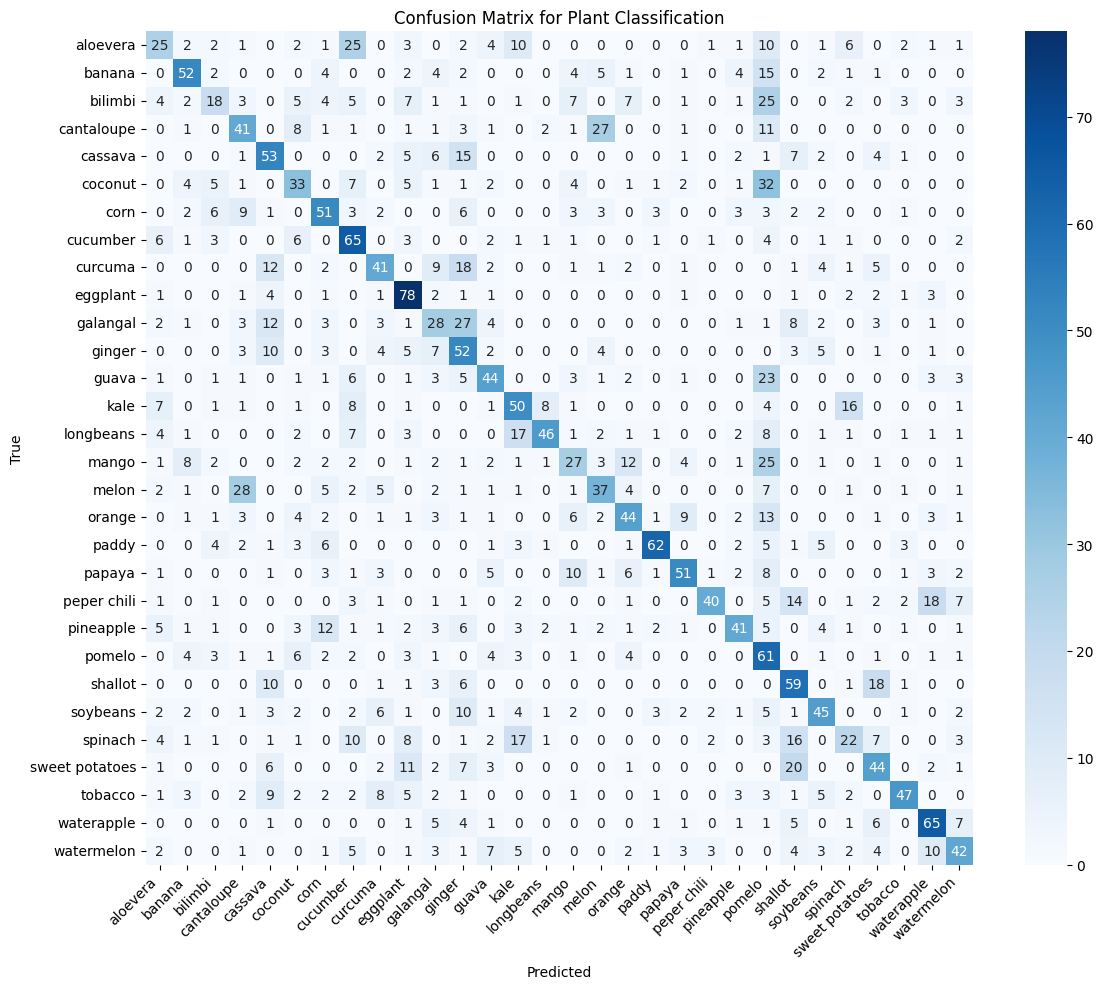

Test Accuracy: 45.50%
Accuracy for aloevera: 25.00%
Accuracy for banana: 52.00%
Accuracy for bilimbi: 18.00%
Accuracy for cantaloupe: 41.00%
Accuracy for cassava: 53.00%
Accuracy for coconut: 33.00%
Accuracy for corn: 51.00%
Accuracy for cucumber: 65.66%
Accuracy for curcuma: 41.00%
Accuracy for eggplant: 78.00%
Accuracy for galangal: 28.00%
Accuracy for ginger: 52.00%
Accuracy for guava: 44.00%
Accuracy for kale: 50.00%
Accuracy for longbeans: 46.00%
Accuracy for mango: 27.00%
Accuracy for melon: 37.00%
Accuracy for orange: 44.00%
Accuracy for paddy: 62.00%
Accuracy for papaya: 51.00%
Accuracy for peper chili: 40.00%
Accuracy for pineapple: 41.00%
Accuracy for pomelo: 61.00%
Accuracy for shallot: 59.00%
Accuracy for soybeans: 45.45%
Accuracy for spinach: 22.00%
Accuracy for sweet potatoes: 44.00%
Accuracy for tobacco: 47.00%
Accuracy for waterapple: 65.00%
Accuracy for watermelon: 42.00%


In [ ]:
#prediction
model = PlantCNN(num_classes=30, input_size=(3, 224, 224)).to(device)
model.load_state_dict(torch.load("plant_cnn.pth"))
model.eval()

#result lists
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Predicting on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#convert to numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
#plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Plant Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#accuracy
test_accuracy_regularcnn = 100 * np.sum(np.diag(cm)) / np.sum(cm)
print(f"Test Accuracy: {test_accuracy_regularcnn:.2f}%")

#per class accuracy
per_class_acc = 100 * np.diag(cm) / np.sum(cm, axis=1)
for i, class_name in enumerate(class_names):
    print(f"Accuracy for {class_name}: {per_class_acc[i]:.2f}%")

## Resnet18

In [ ]:
#load resnet18
model = models.resnet18(pretrained=True)

num_classes = 30
model.fc = nn.Linear(model.fc.in_features, num_classes)  #replace final layer

model = model.to(device)

#optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()
#training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  #forward
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        train_loop.set_postfix(loss=running_loss / (train_loop.n + 1))

    train_accuracy = 100 * correct_train / total_train

    #validation
    model.eval()
    correct_val, total_val = 0, 0
    val_loss = 0.0

    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            val_loop.set_postfix(val_loss=val_loss / (val_loop.n + 1))

    val_accuracy = 100 * correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")
end_time= time.time()
resnet18_time = end_time - start_time

print("Training complete!")
print("Training Resnet18 takes: ",resnet18_time)
#save
torch.save(model.state_dict(), "resnet18_plant.pth")
print("Model saved as resnet18_plant.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


Epoch 1/5, Loss: 1.0851, Train Accuracy: 67.14%, Val Loss: 0.9013, Val Accuracy: 72.41%


Epoch 2/5, Loss: 0.5471, Train Accuracy: 82.58%, Val Loss: 0.6333, Val Accuracy: 81.68%


Epoch 3/5, Loss: 0.3696, Train Accuracy: 87.61%, Val Loss: 0.5715, Val Accuracy: 82.84%


Epoch 4/5, Loss: 0.2859, Train Accuracy: 90.44%, Val Loss: 0.4011, Val Accuracy: 87.29%


Epoch 5/5, Loss: 0.2464, Train Accuracy: 91.84%, Val Loss: 0.3001, Val Accuracy: 90.50%
Training complete!
Training Resnet18 takes:  989.0794727802277
Model saved as resnet18_plant.pth


### Result of Resnet18

Predicting on Test Set: 100%|██████████| 94/94 [00:17<00:00,  5.33it/s]


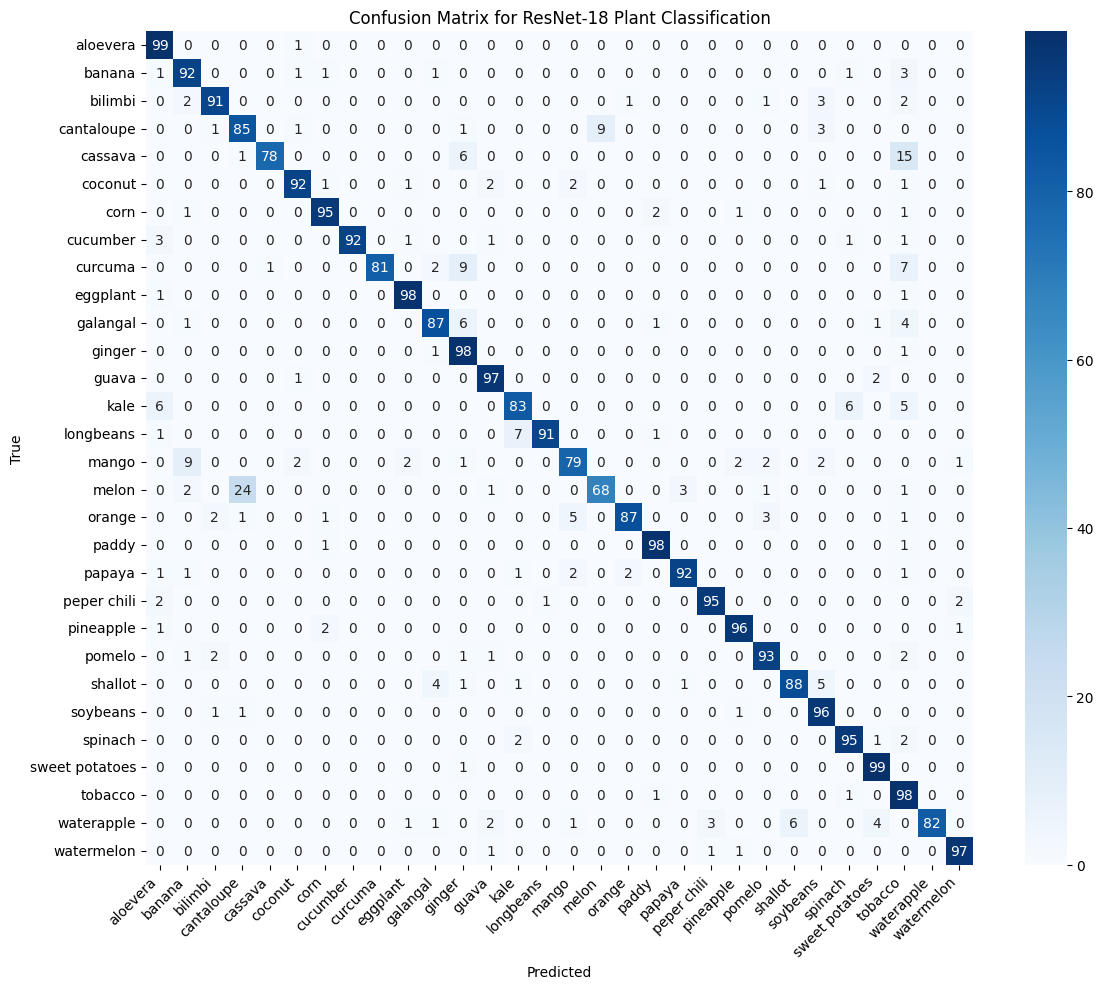

Test Accuracy: 90.79%


In [ ]:
#resnet18 test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Predicting on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for ResNet-18 Plant Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#test accuracy
test_accuracy_resnet18 = 100 * np.sum(np.diag(cm)) / np.sum(cm)
print(f"Test Accuracy: {test_accuracy_resnet18:.2f}%")

## SE-Resnet18

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#SE-ResNet18 Implementation
def create_se_resnet18(num_classes=30):
    model = models.resnet18(pretrained=True)

    class SEBlock(nn.Module):
        def __init__(self, channel, reduction=16):
            super(SEBlock, self).__init__()
            self.channel = channel
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
            self.fc = nn.Sequential(
                nn.Linear(channel, channel // reduction, bias=False),
                nn.ReLU(inplace=True),
                nn.Linear(channel // reduction, channel, bias=False),
                nn.Sigmoid()
            )

        def forward(self, x):
            b, c, h, w = x.size()
            assert c == self.channel, f"Channel mismatch: expected {self.channel}, got {c}"
            y = self.avg_pool(x).view(b, c)
            y = self.fc(y).view(b, c, 1, 1)
            return x * y.expand_as(x)

    layer1 = model.layer1
    layer2 = model.layer2
    layer3 = model.layer3
    layer4 = model.layer4

    model.conv1 = nn.Sequential(
        model.conv1,  #3 channels to 64 channels
        SEBlock(64)   #apply squeeze and excitation to get channel attention
    )
    model.layer1 = nn.Sequential(
        SEBlock(64), #second SE computation
        *layer1
    )
    model.layer2 = nn.Sequential(
        SEBlock(64),  #third SE computation
        *layer2
    )
    model.layer3 = nn.Sequential(
        SEBlock(128), #fourth SE with 128 channels
        *layer3
    )
    model.layer4 = nn.Sequential(
        SEBlock(256), #final SE with 256 channels
        *layer4
    )

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model

seresnet18_model = create_se_resnet18(num_classes=30).to(device)

#optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seresnet18_model.parameters(), lr=1e-4)

#training
start_time = time.time()
num_epochs = 5
for epoch in range(num_epochs):
    seresnet18_model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = seresnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        train_loop.set_postfix(loss=running_loss / (train_loop.n + 1))

    train_accuracy = 100 * correct_train / total_train

    #validation
    seresnet18_model.eval()
    correct_val, total_val = 0, 0
    val_loss = 0.0

    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = seresnet18_model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            val_loop.set_postfix(val_loss=val_loss / (val_loop.n + 1))

    val_accuracy = 100 * correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")
end_time = time.time()
seresnet18_time = end_time-start_time

#save
print("Training complete!")
print("Training SEResnet18 takes: ",seresnet18_time)
torch.save(seresnet18_model.state_dict(), "se_resnet18_plant.pth")
print("Model saved as se_resnet18_plant.pth")


Epoch 1/5, Loss: 0.5518, Train Accuracy: 85.88%, Val Loss: 0.1588, Val Accuracy: 95.21%


Epoch 2/5, Loss: 0.1066, Train Accuracy: 97.00%, Val Loss: 0.1141, Val Accuracy: 96.57%


Epoch 3/5, Loss: 0.0607, Train Accuracy: 98.28%, Val Loss: 0.1013, Val Accuracy: 96.67%


Epoch 4/5, Loss: 0.0501, Train Accuracy: 98.72%, Val Loss: 0.0710, Val Accuracy: 97.69%


Epoch 5/5, Loss: 0.0356, Train Accuracy: 98.94%, Val Loss: 0.1319, Val Accuracy: 95.94%
Training complete!
Training SEResnet18 takes:  1064.1147754192352
Model saved as se_resnet18_plant.pth


### Result of SE-Resnet18

Predicting on Test Set: 100%|██████████| 94/94 [00:17<00:00,  5.51it/s]


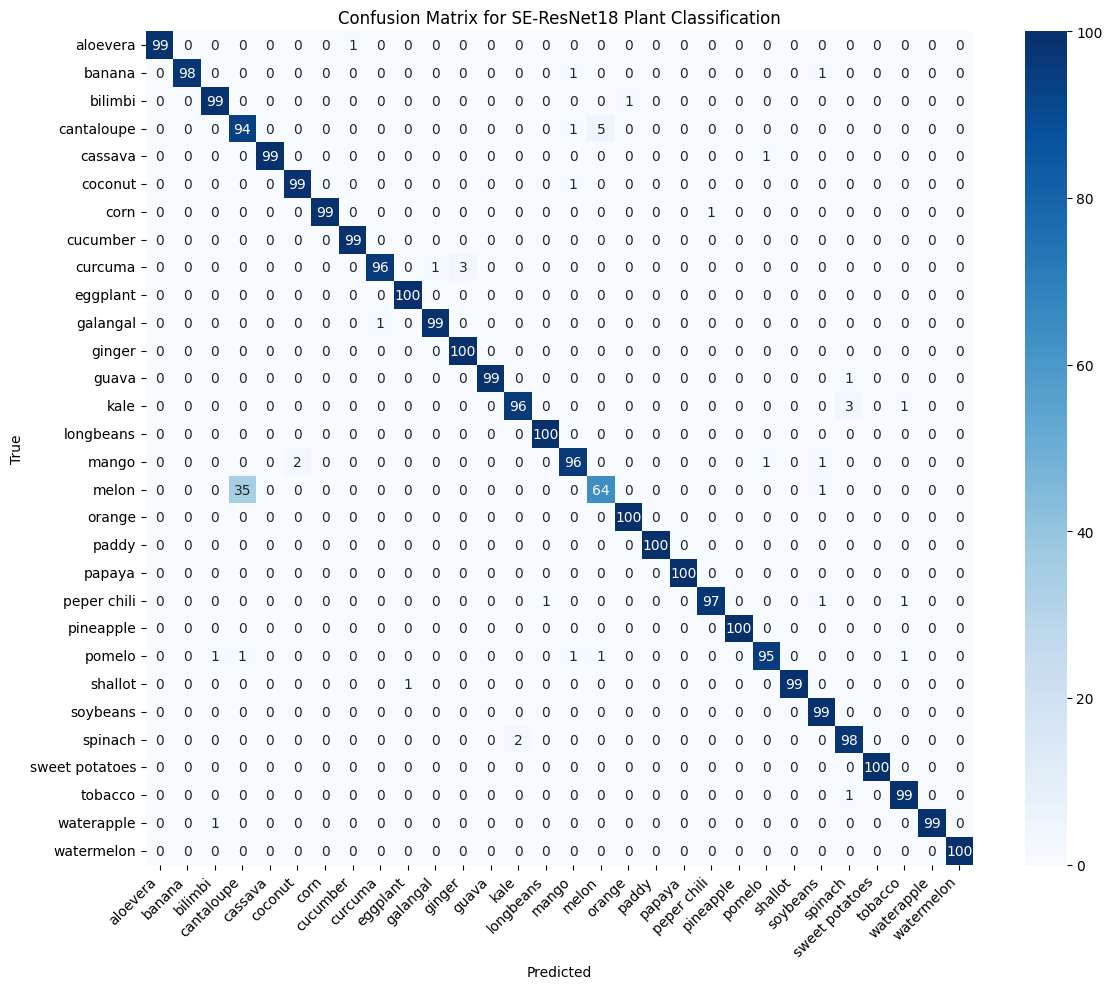

Test Accuracy: 97.46%


In [ ]:
#test se-resnet18
seresnet18_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Predicting on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = seresnet18_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for SE-ResNet18 Plant Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#test accuracy
test_accuracy_seresnet18 = 100 * np.sum(np.diag(cm)) / np.sum(cm)
print(f"Test Accuracy: {test_accuracy_seresnet18:.2f}%")


## Convolutional Block Attention Module(CBAM)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#CBAM Implementation
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, reduction=16): #apply reduction factor 16
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) #get adaptive average pooling
        self.max_pool = nn.AdaptiveMaxPool2d(1) #get adaptive max pooling
        self.fc = nn.Sequential( #feed max and avg to small nn to get channel attention
            nn.Conv2d(in_planes, in_planes // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // reduction, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid() #apply sigmoid to get 0-1 for image

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)
#after refind feature maps with channel, get spatial attention
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False) #apply 7x7 convolution
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)
#create cbam block
class CBAMBlock(nn.Module):
    def __init__(self, in_planes, reduction=16):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        ca = self.channel_attention(x) * x  #feed channel attention
        sa = self.spatial_attention(ca) * ca  #feed patial attention
        return sa

# Modify on Resnet18 (CBAM-Resnet18)
def create_cbam_resnet18(num_classes=30):
    model = models.resnet18(pretrained=True)

    layer1 = model.layer1
    layer2 = model.layer2
    layer3 = model.layer3
    layer4 = model.layer4

    model.conv1 = nn.Sequential(
        model.conv1,  #fetch 64 channels
        CBAMBlock(64) #first cbam
    )
    model.layer1 = nn.Sequential(
        CBAMBlock(64),  #second cbam
        *layer1
    )
    model.layer2 = nn.Sequential(
        CBAMBlock(64),  #third
        *layer2
    )
    model.layer3 = nn.Sequential(
        CBAMBlock(128), #fourth
        *layer3
    )
    model.layer4 = nn.Sequential(
        CBAMBlock(256), #fifth
        *layer4
    )

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model

#initialization
cbamresnet18_model = create_cbam_resnet18(num_classes=30).to(device)

#optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cbamresnet18_model.parameters(), lr=1e-4)

#training
start_time= time.time()
num_epochs = 5
for epoch in range(num_epochs):
    cbamresnet18_model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cbamresnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        train_loop.set_postfix(loss=running_loss / (train_loop.n + 1))

    train_accuracy = 100 * correct_train / total_train

    #validation
    cbamresnet18_model.eval()
    correct_val, total_val = 0, 0
    val_loss = 0.0

    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = cbamresnet18_model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            val_loop.set_postfix(val_loss=val_loss / (val_loop.n + 1))

    val_accuracy = 100 * correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")
end_time = time.time()
cbamresnet18_time = end_time - start_time

#save
print("Training complete!")
print("CBAM-Resnet18 takes: ",cbamresnet18_time)
torch.save(cbamresnet18_model.state_dict(), "cbam_resnet18_plant.pth")
print("Model saved as cbam_resnet18_plant.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.2MB/s]


Epoch 1/5, Loss: 0.6157, Train Accuracy: 83.91%, Val Loss: 0.1626, Val Accuracy: 94.52%


Epoch 2/5, Loss: 0.1211, Train Accuracy: 96.63%, Val Loss: 0.1237, Val Accuracy: 96.07%


Epoch 3/5, Loss: 0.0704, Train Accuracy: 97.96%, Val Loss: 0.0913, Val Accuracy: 96.93%


Epoch 4/5, Loss: 0.0566, Train Accuracy: 98.31%, Val Loss: 0.1222, Val Accuracy: 96.27%


Epoch 5/5, Loss: 0.0477, Train Accuracy: 98.58%, Val Loss: 0.0894, Val Accuracy: 97.23%
Training complete!
CBAM-Resnet18 takes:  1190.9982364177704
Model saved as cbam_resnet18_plant.pth


Predicting on Test Set: 100%|██████████| 94/94 [00:18<00:00,  5.09it/s]


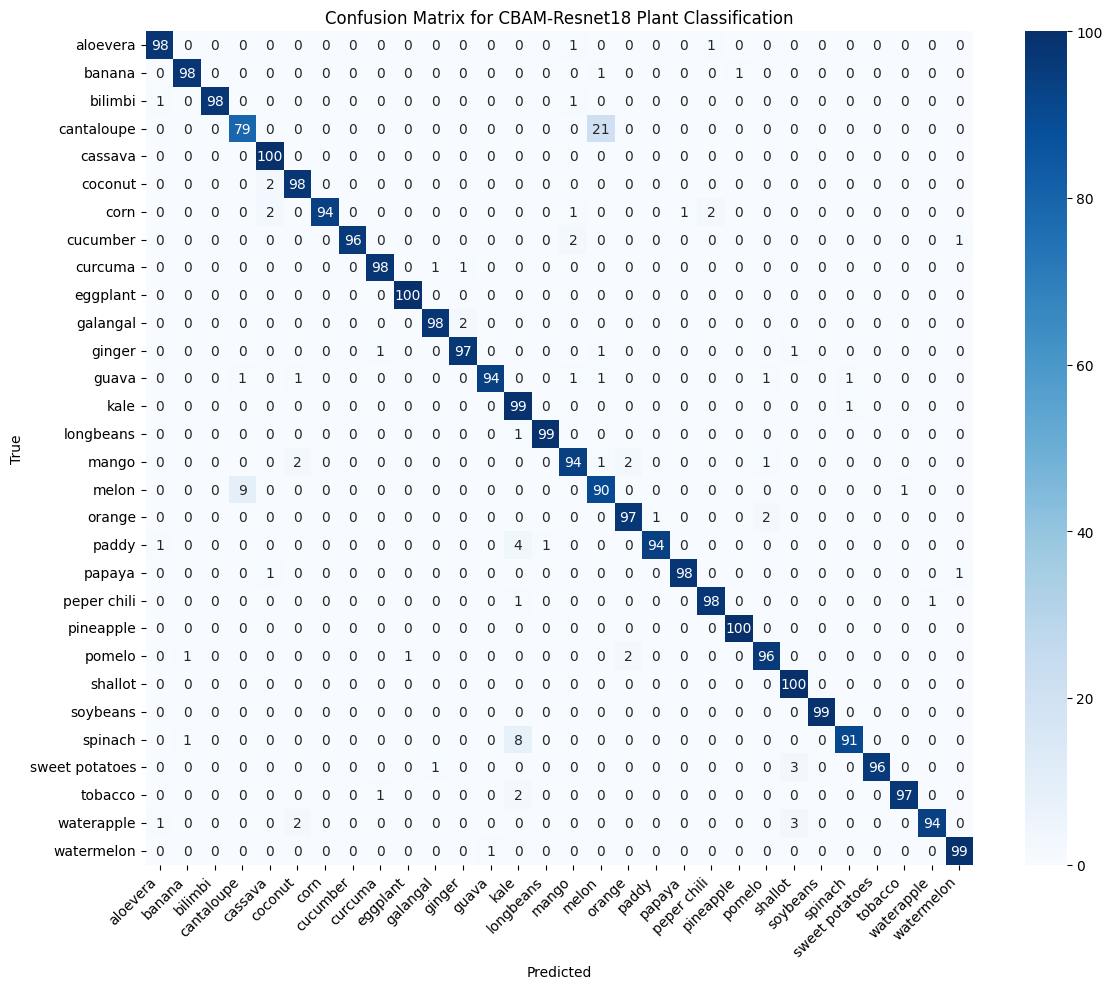

Test Accuracy: 96.36%


In [ ]:
#test cbam
cbamresnet18_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Predicting on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = cbamresnet18_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for CBAM-Resnet18 Plant Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#test accuracy
test_accuracy_cbamresnet18 = 100 * np.sum(np.diag(cm)) / np.sum(cm)
print(f"Test Accuracy: {test_accuracy_cbamresnet18:.2f}%")


## Efficient Channel Attention

In [11]:
#ECA Implementation
class ECABlock(nn.Module):
    def __init__(self, channels, k_size=3):
        super(ECABlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Global average pooling
        y = self.avg_pool(x)
        # Reshape for 1D convolution: [B, C, 1, 1] -> [B, 1, C]
        y = y.squeeze(-1).transpose(-1, -2)
        # Apply 1D convolution
        y = self.conv(y)
        # Reshape back and apply sigmoid: [B, 1, C] -> [B, C, 1, 1]
        y = y.transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

# ECA-ResNet18 Implementation
def create_eca_resnet18(num_classes=30):
    model = models.resnet18(pretrained=True)

    layer1 = model.layer1
    layer2 = model.layer2
    layer3 = model.layer3
    layer4 = model.layer4

    model.conv1 = nn.Sequential(
        model.conv1,  # 3 to 64
        ECABlock(64)
    )
    model.layer1 = nn.Sequential(
        ECABlock(64),  #in 64
        *layer1        #out 64
    )
    model.layer2 = nn.Sequential(
        ECABlock(64),  #in 64
        *layer2        #out 128
    )
    model.layer3 = nn.Sequential(
        ECABlock(128), #in 128
        *layer3        #out 256
    )
    model.layer4 = nn.Sequential(
        ECABlock(256), #in 256
        *layer4        #out 512
    )

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model

# Initialize model
ecaresnet18_model = create_eca_resnet18(num_classes=30).to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ecaresnet18_model.parameters(), lr=1e-4)

# Training loop
start_time = time.time()
num_epochs = 5
for epoch in range(num_epochs):
    ecaresnet18_model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = ecaresnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        train_loop.set_postfix(loss=running_loss / (train_loop.n + 1))

    train_accuracy = 100 * correct_train / total_train

    # Validation
    ecaresnet18_model.eval()
    correct_val, total_val = 0, 0
    val_loss = 0.0

    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = ecaresnet18_model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            val_loop.set_postfix(val_loss=val_loss / (val_loop.n + 1))

    val_accuracy = 100 * correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")
end_time = time.time()
ecaresnet18_time = end_time - start_time

# Save model
print("Training complete!")
print("Training ECA-Resnet18 takes: ", ecaresnet18_time)
torch.save(ecaresnet18_model.state_dict(), "eca_resnet18_plant.pth")
print("Model saved as eca_resnet18_plant.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 0.5478, Train Accuracy: 85.71%, Val Loss: 0.1732, Val Accuracy: 93.76%


Epoch 2/5, Loss: 0.1120, Train Accuracy: 96.93%, Val Loss: 0.0839, Val Accuracy: 97.19%


Epoch 3/5, Loss: 0.0669, Train Accuracy: 98.06%, Val Loss: 0.1214, Val Accuracy: 96.01%


Epoch 4/5, Loss: 0.0510, Train Accuracy: 98.64%, Val Loss: 0.1235, Val Accuracy: 95.94%


Epoch 5/5, Loss: 0.0487, Train Accuracy: 98.69%, Val Loss: 0.0885, Val Accuracy: 97.00%
Training complete!
Training ECA-Resnet18 takes:  1104.1782982349396
Model saved as eca_resnet18_plant.pth


Predicting on Test Set: 100%|██████████| 94/94 [00:17<00:00,  5.29it/s]


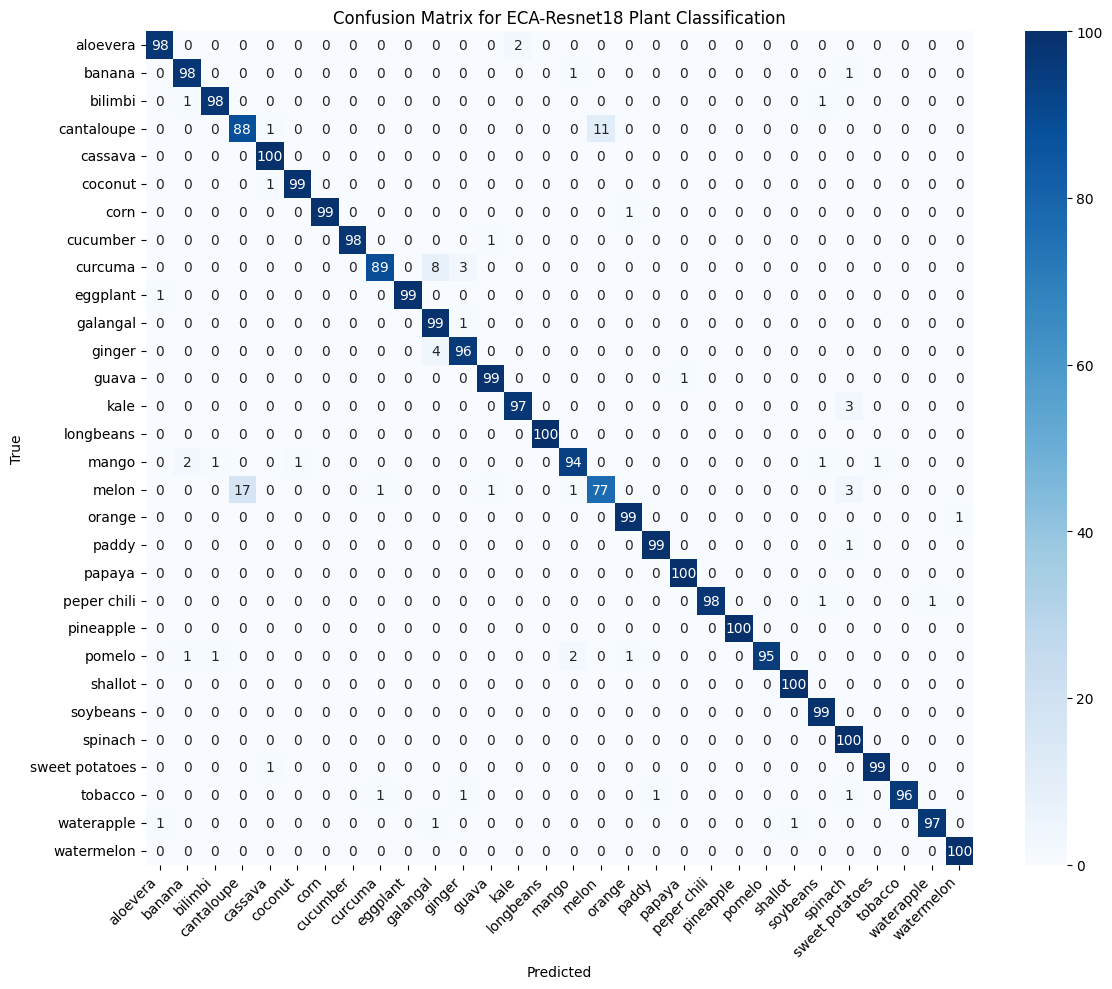

Test Accuracy: 97.06%


In [ ]:
#test eca-resnet18
ecaresnet18_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Predicting on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = ecaresnet18_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for ECA-Resnet18 Plant Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#test accuracy
test_accuracy_ecaresnet18 = 100 * np.sum(np.diag(cm)) / np.sum(cm)
print(f"Test Accuracy: {test_accuracy_ecaresnet18:.2f}%")


## ECA-Spatial-Resnet18

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ECA + Spatial Attention Hybrid Block
class ECABlock(nn.Module):
    def __init__(self, channels, k_size=3):
        super(ECABlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = y.squeeze(-1).transpose(-1, -2)
        y = self.conv(y)
        y = y.transpose(-1, -2).unsqueeze(-1)
        return self.sigmoid(y)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out)

class ECASpatialBlock(nn.Module):
    def __init__(self, channels, k_size=3):
        super(ECASpatialBlock, self).__init__()
        self.eca = ECABlock(channels, k_size)  # ECA replaces Channel Attention
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        eca_out = self.eca(x) * x  # Apply ECA attention
        sa_out = self.spatial_attention(eca_out) * eca_out  # Apply Spatial attention
        return sa_out

# ECA-Spatial-ResNet18 Implementation
def create_eca_spatial_resnet18(num_classes=30):
    model = models.resnet18(pretrained=True)

    layer1 = model.layer1
    layer2 = model.layer2
    layer3 = model.layer3
    layer4 = model.layer4

    model.conv1 = nn.Sequential(
        model.conv1,        # 3 → 64
        ECASpatialBlock(64) # ECA-Spatial after conv1
    )
    model.layer1 = nn.Sequential(
        ECASpatialBlock(64), # Input: 64 channels
        *layer1              # Output: 64 channels
    )
    model.layer2 = nn.Sequential(
        ECASpatialBlock(64), # Input: 64 channels
        *layer2              # Output: 128 channels
    )
    model.layer3 = nn.Sequential(
        ECASpatialBlock(128), # Input: 128 channels
        *layer3               # Output: 256 channels
    )
    model.layer4 = nn.Sequential(
        ECASpatialBlock(256), # Input: 256 channels
        *layer4               # Output: 512 channels
    )

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model

# Initialize model
ecaspatialresnet18_model = create_eca_spatial_resnet18(num_classes=30).to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ecaspatialresnet18_model.parameters(), lr=1e-4)

# Training loop
start_time = time.time()
num_epochs = 5
for epoch in range(num_epochs):
    ecaspatialresnet18_model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = ecaspatialresnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        train_loop.set_postfix(loss=running_loss / (train_loop.n + 1))

    train_accuracy = 100 * correct_train / total_train

    # Validation
    ecaspatialresnet18_model.eval()
    correct_val, total_val = 0, 0
    val_loss = 0.0

    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = ecaspatialresnet18_model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            val_loop.set_postfix(val_loss=val_loss / (val_loop.n + 1))

    val_accuracy = 100 * correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")
end_time = time.time()
ecaspatialresnet18_time = end_time - start_time
# Save model
print("Training complete!")
print("ECA-Spatial-Resnet18 training takes: ",ecaspatialresnet18_time)
torch.save(ecaspatialresnet18_model.state_dict(), "eca_spatial_resnet18_plant.pth")
print("Model saved as eca_spatial_resnet18_plant.pth")

Epoch 1/5, Loss: 0.6154, Train Accuracy: 83.51%, Val Loss: 0.1726, Val Accuracy: 94.65%


Epoch 2/5, Loss: 0.1244, Train Accuracy: 96.68%, Val Loss: 0.1324, Val Accuracy: 95.41%


Epoch 3/5, Loss: 0.0646, Train Accuracy: 98.29%, Val Loss: 0.0887, Val Accuracy: 97.06%


Epoch 4/5, Loss: 0.0514, Train Accuracy: 98.58%, Val Loss: 0.1195, Val Accuracy: 96.17%


Epoch 5/5, Loss: 0.0416, Train Accuracy: 98.87%, Val Loss: 0.1056, Val Accuracy: 96.47%
Training complete!
ECA-Spatial-Resnet18 training takes:  1110.456259727478
Model saved as eca_spatial_resnet18_plant.pth


Predicting on Test Set: 100%|██████████| 94/94 [00:18<00:00,  5.22it/s]


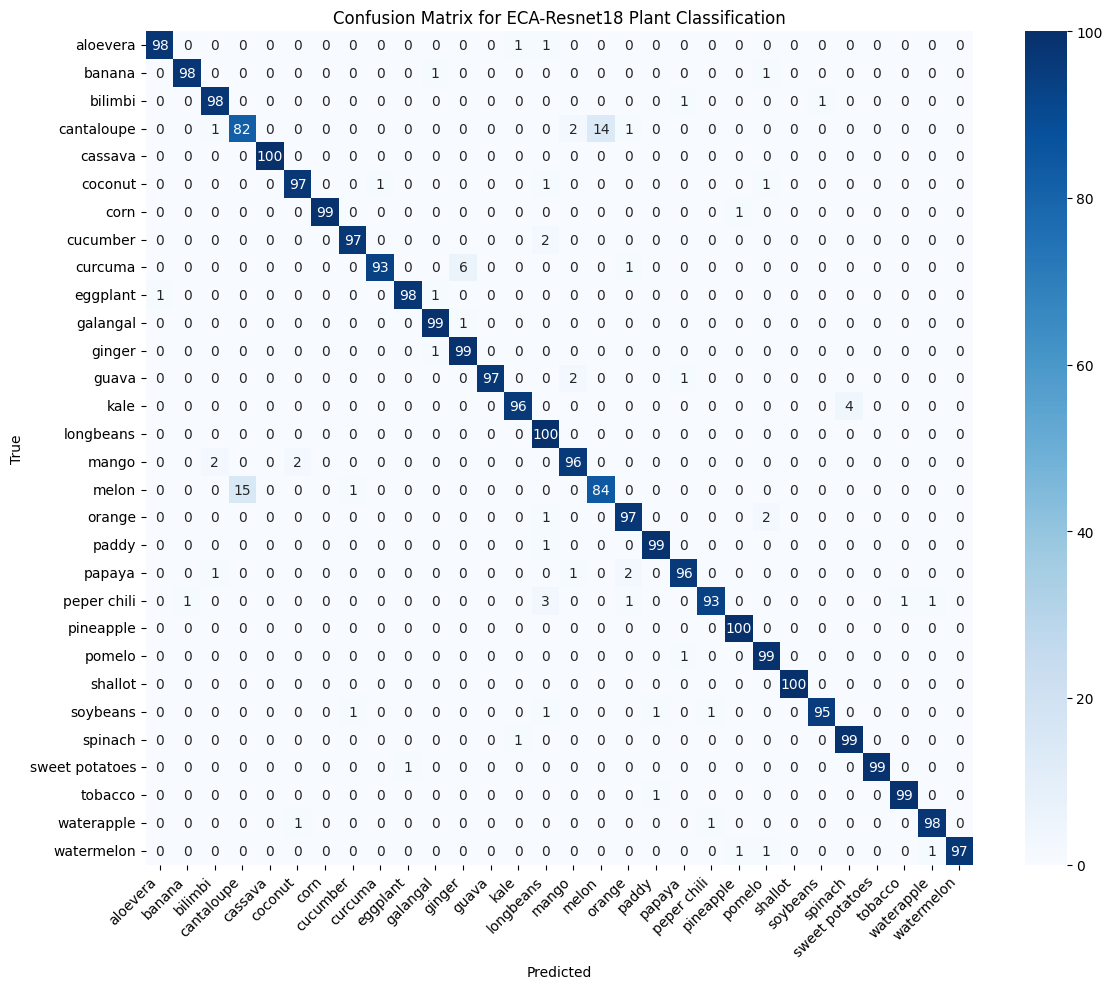

Test Accuracy: 96.80%


In [ ]:
#test eca + spatial attention block
ecaspatialresnet18_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Predicting on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = ecaspatialresnet18_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for ECA-Resnet18 Plant Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#test accuracy
test_accuracy_hybridresnet18 = 100 * np.sum(np.diag(cm)) / np.sum(cm)
print(f"Test Accuracy: {test_accuracy_hybridresnet18:.2f}%")


## Accuracies

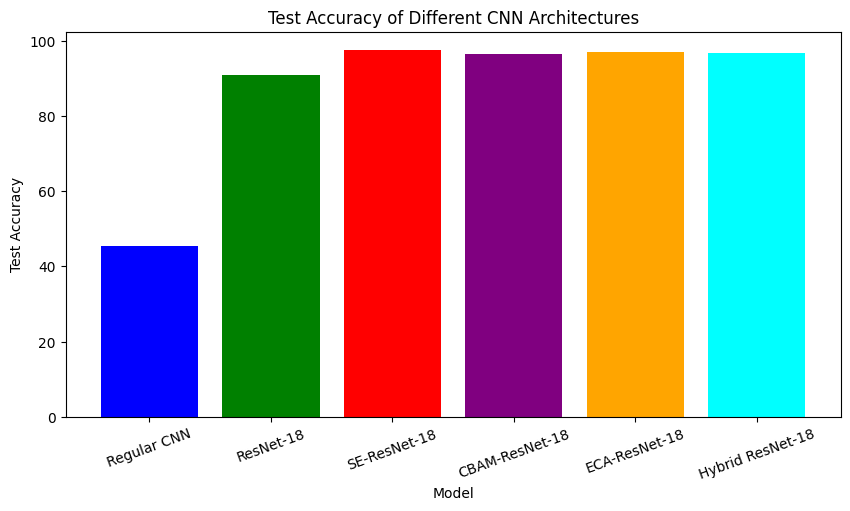

In [ ]:
models = [
    "Regular CNN",
    "ResNet-18",
    "SE-ResNet-18",
    "CBAM-ResNet-18",
    "ECA-ResNet-18",
    "Hybrid ResNet-18"
]
accuracies = [
    test_accuracy_regularcnn,
    test_accuracy_resnet18,
    test_accuracy_seresnet18,
    test_accuracy_cbamresnet18,
    test_accuracy_ecaresnet18,
    test_accuracy_hybridresnet18
]

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])

# Labels and title
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy of Different CNN Architectures")
plt.xticks(rotation=20)

# Show the plot
plt.show()

## Training times

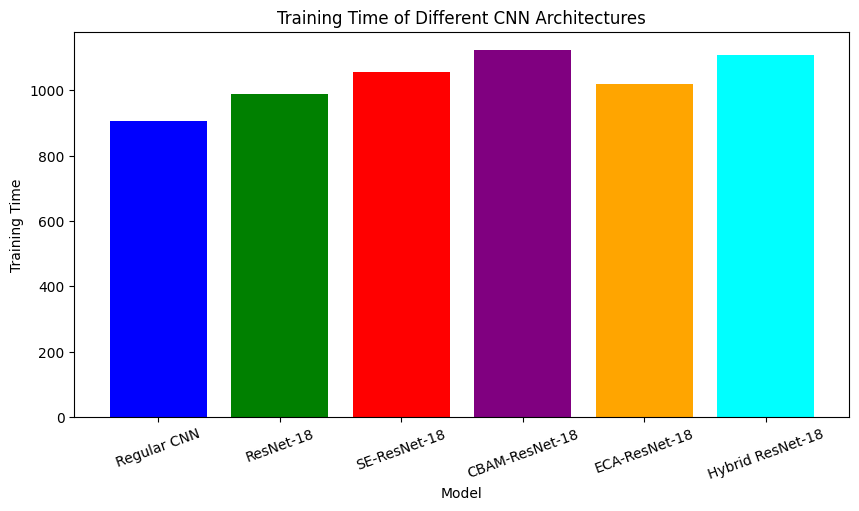

In [ ]:
models = [
    "Regular CNN",
    "ResNet-18",
    "SE-ResNet-18",
    "CBAM-ResNet-18",
    "ECA-ResNet-18",
    "Hybrid ResNet-18"
]
trainings = [
    regularcnn_time,
    resnet18_time,
    seresnet18_time,
    cbamresnet18_time,
    ecaresnet18_time,
    ecaspatialresnet18_time
]

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(models, trainings, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])

# Labels and title
plt.xlabel("Model")
plt.ylabel("Training Time")
plt.title("Training Time of Different CNN Architectures")
plt.xticks(rotation=20)

# Show the plot
plt.show()

## TorchCAM Visualization

In [ ]:
!pip install torchcam

In [7]:
#visualization
import torch
import torch.nn as nn
import torchvision.models as tv_models
from torchvision import transforms
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### Regular CNN vs Resnet18

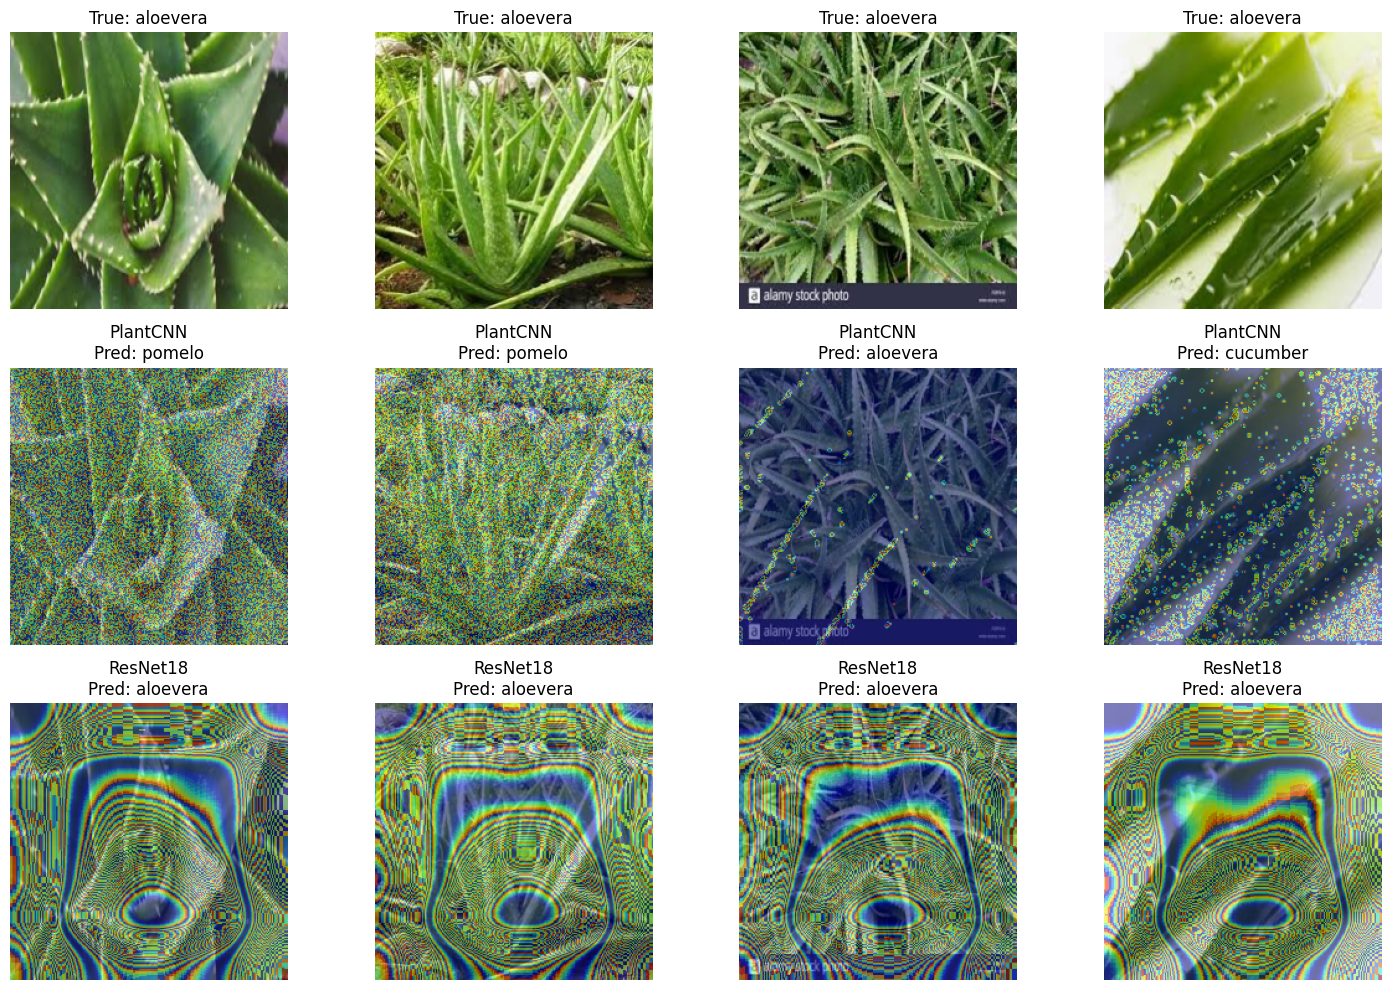

In [ ]:

#Regular CNN
class PlantCNN(nn.Module):
    def __init__(self, num_classes, input_size=(3, 224, 224)):
        super(PlantCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self._to_linear = self._get_conv_output_size(input_size)
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_conv_output_size(self, input_size):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            x = self.pool(torch.relu(self.conv1(dummy_input)))
            x = self.pool(torch.relu(self.conv2(x)))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Grad-CAM function
def show_gradcam_multiple_models(test_loader, class_names, device, model_paths, model_names, num_images=4):
    images, labels = next(iter(test_loader))
    images = images[:num_images].to(device)
    labels = labels[:num_images]

    plt.figure(figsize=(15, 4 * len(model_paths) + 2))

    for model_idx, (model_path, model_name) in enumerate(zip(model_paths, model_names)):
        if "plant_cnn" in model_path.lower():
            model = PlantCNN(num_classes=len(class_names), input_size=(3, 224, 224))
            target_layer = "conv2"
        elif "resnet18_plant" in model_path.lower():
            model = tv_models.resnet18(pretrained=False)
            model.fc = nn.Linear(model.fc.in_features, len(class_names))
            target_layer = "layer4"
        else:
            raise ValueError(f"Unknown model type in path: {model_path}")

        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict, strict=True)
        model.to(device)
        model.eval()

        cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        if model_idx == 0:
            for idx in range(num_images):
                img = images[idx].cpu()
                img = img * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
                img = transforms.ToPILImage()(img)
                plt.subplot(len(model_paths) + 1, num_images, idx + 1)
                plt.imshow(img)
                plt.title(f'True: {class_names[labels[idx]]}')
                plt.axis('off')

        for idx in range(num_images):
            activation_map = cam_extractor(predicted[idx].item(), outputs[idx].unsqueeze(0))
            activation_map_np = activation_map[0].cpu().numpy()

            if len(activation_map_np.shape) == 3:
                activation_map_2d = np.mean(activation_map_np, axis=0)
            elif len(activation_map_np.shape) == 1:
                size = int(np.sqrt(activation_map_np.size))
                activation_map_2d = activation_map_np.reshape(size, size)
            else:
                activation_map_2d = activation_map_np

            activation_map_2d = (activation_map_2d - activation_map_2d.min()) / \
                               (activation_map_2d.max() - activation_map_2d.min() + 1e-8) * 255
            activation_map_2d = activation_map_2d.astype(np.uint8)
            cam_image = Image.fromarray(activation_map_2d)

            img = images[idx].cpu()
            img = img * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
            img = transforms.ToPILImage()(img)

            result = overlay_mask(img, cam_image, alpha=0.5)

            plt.subplot(len(model_paths) + 1, num_images, (model_idx + 1) * num_images + idx + 1)
            plt.imshow(result)
            plt.title(f'{model_name}\nPred: {class_names[predicted[idx]]}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_paths = ["plant_cnn.pth", "resnet18_plant.pth"]
model_names = ["PlantCNN", "ResNet18"]

show_gradcam_multiple_models(test_loader, class_names, device, model_paths, model_names, num_images=4)

In [8]:
def show_gradcam(model, test_loader, class_names, device, num_images=4):
    model.eval()
    images, labels = next(iter(test_loader))
    images = images[:num_images].to(device)
    labels = labels[:num_images]

    plt.figure(figsize=(15, 5))  # Adjusted for a single row plus original images

    # Original images
    for idx in range(num_images):
        img = images[idx].cpu()
        img = img * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
        img = transforms.ToPILImage()(img)
        plt.subplot(2, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'True: {class_names[labels[idx]]}')
        plt.axis('off')

    # Grad-CAM
    cam_extractor = SmoothGradCAMpp(model, target_layer="layer4")
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    for idx in range(num_images):
        activation_map = cam_extractor(predicted[idx].item(), outputs[idx].unsqueeze(0))
        activation_map_np = activation_map[0].cpu().numpy()

        if len(activation_map_np.shape) == 3:
            activation_map_2d = np.mean(activation_map_np, axis=0)
        elif len(activation_map_np.shape) == 1:
            size = int(np.sqrt(activation_map_np.size))
            activation_map_2d = activation_map_np.reshape(size, size)
        else:
            activation_map_2d = activation_map_np

        activation_map_2d = (activation_map_2d - activation_map_2d.min()) / \
                           (activation_map_2d.max() - activation_map_2d.min() + 1e-8) * 255
        activation_map_2d = activation_map_2d.astype(np.uint8)
        cam_image = Image.fromarray(activation_map_2d)

        img = images[idx].cpu()
        img = img * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
        img = transforms.ToPILImage()(img)

        result = overlay_mask(img, cam_image, alpha=0.5)

        plt.subplot(2, num_images, num_images + idx + 1)
        plt.imshow(result)
        plt.title(f'Pred: {class_names[predicted[idx]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### SE-Resnet18

Generating Grad-CAM for SE-ResNet18


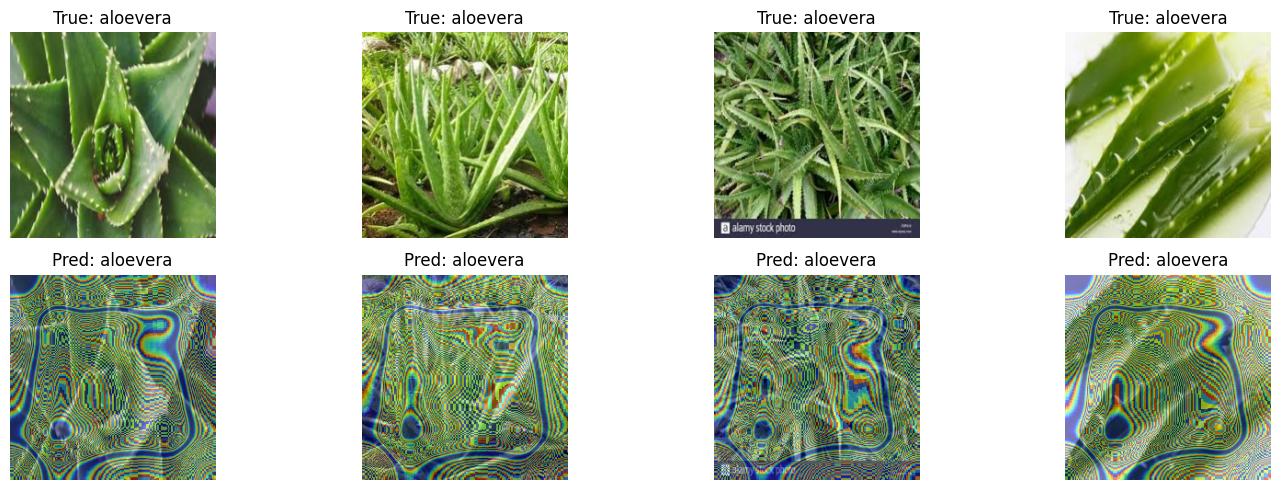

In [9]:
print("Generating Grad-CAM for SE-ResNet18")
show_gradcam(seresnet18_model, test_loader, class_names, device, num_images=4)

Generating Grad-CAM for CBAM-ResNet18


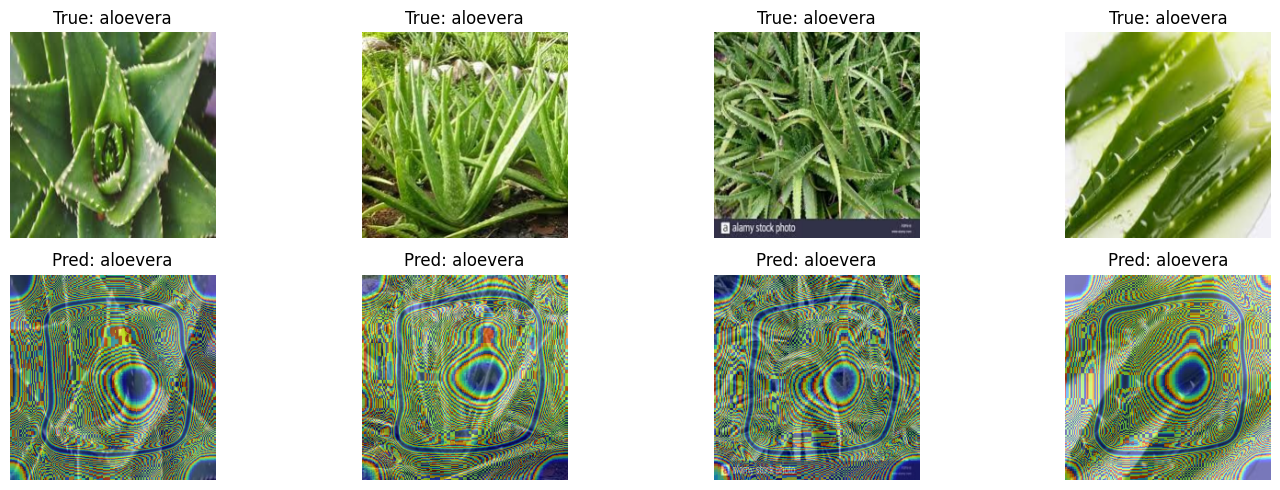

In [10]:
print("Generating Grad-CAM for CBAM-ResNet18")
show_gradcam(cbamresnet18_model, test_loader, class_names, device, num_images=4)

### ECA-Resnet18

Generating Grad-CAM for ECA-ResNet18


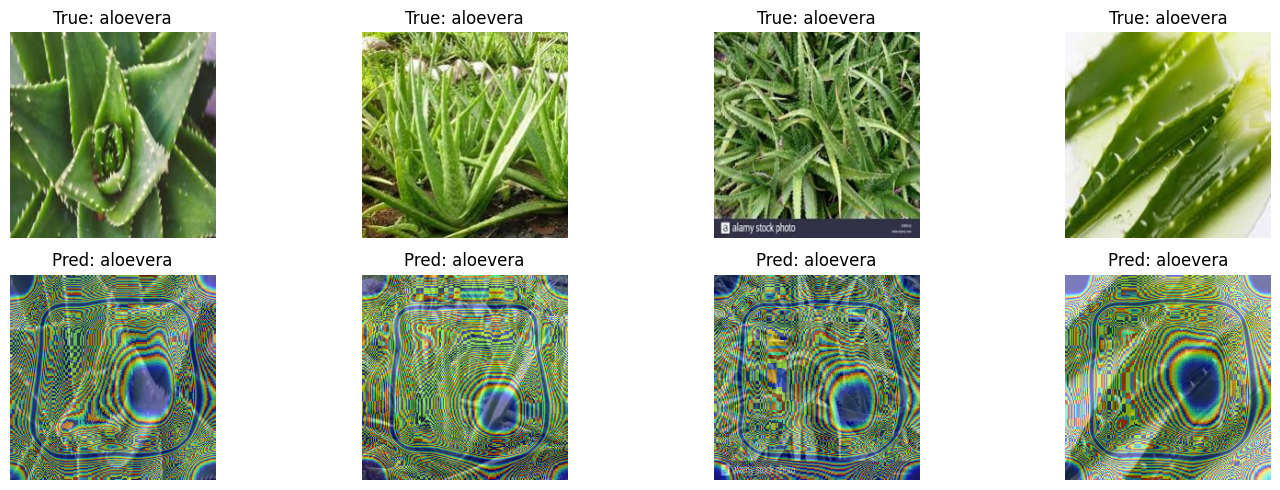

In [12]:
print("Generating Grad-CAM for ECA-ResNet18")
show_gradcam(ecaresnet18_model, test_loader, class_names, device, num_images=4)

### ECA-Spatial-Resnet18

Generating Grad-CAM for ECA-ResNet18


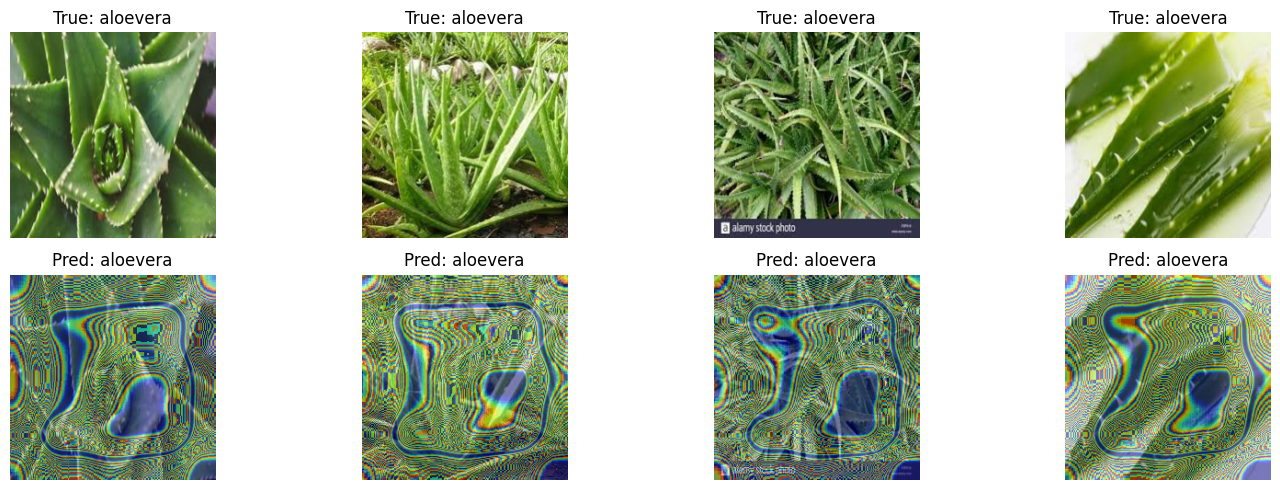

In [9]:
print("Generating Grad-CAM for ECA-Spatial-ResNet18")
show_gradcam(ecaspatialresnet18_model, test_loader, class_names, device, num_images=4)